# CATE Estimation Disparity Between Minority and Majority Groups

In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import econml
from econml.grf import CausalForest
from RATE import *
# set numpy seed
np.random.seed(0)

In [2]:
NUM_SIMULATIONS = 50  # global constant for number of simulations

In [3]:
global_start_time = time.time()

## Simulated Data Generation

The CATE function is completely different among the minority and majority groups

In [4]:
def complicated_function(x):
    return 2 / (1+np.exp(-12*(x-1/2)))

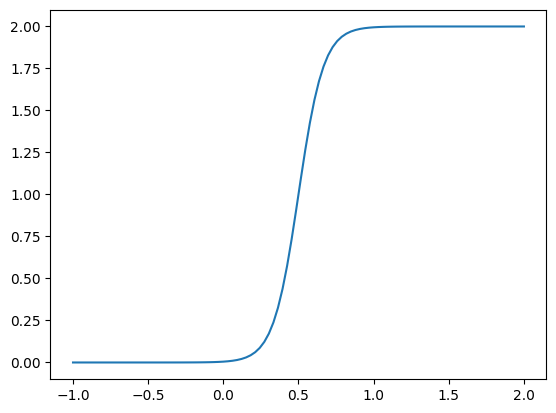

In [8]:
x = np.linspace(-1,2,100)
y = complicated_function(x)
plt.plot(x,y)

In [11]:
def gen_imbalanced_data_complexTE(n=4000, propensity=0.5, p_protect=0.1, m_categorical=2, m_continuous=3, noise_var=1.0):
    # imbalanced protected variable
    X_protect = np.random.choice([0,1], size=(n, 1), p=[1-p_protect, p_protect])
    # some categorical
    X_categorical = np.random.choice([0,1], size=(n, m_categorical), p=[0.5, 0.5])
    # some continuous
    X_continuous = np.random.normal(0, 1, size=(n, m_continuous))
    # m = 1+m_categorical+m_continuous
    X = np.concatenate((X_protect, X_categorical, X_continuous), axis=1)
    # random treatment assignment
    W = np.random.choice([0,1], n, p=[1-propensity, propensity])
    # if the treatment effect is linear, then the linear model is correctly specified
    mu1_min = (1/2) * complicated_function(X_categorical[:,0]) * complicated_function(X_continuous[:,0])
    mu1_maj = (1/2) * complicated_function(X_categorical[:,0]) * complicated_function(X_continuous[:,1])
    mu1 = (1-X_protect[:, 0]) * mu1_maj + X_protect[:, 0] * mu1_min
    mu0 = (-1/2) * complicated_function(X_categorical[:,0]) * complicated_function(X_continuous[:,0])
    Tau = mu1-mu0
    Y = mu0 + W * Tau + np.random.normal(0, np.sqrt(noise_var), n)
    return X, W, Tau, Y

In [12]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_complexTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_complexTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.1075 0.5035 0.0024762748821773543
Some examples of Y: [-0.20957843  1.72683972 -0.43830242 -0.97745347  0.01733449]


In [14]:
print(np.mean(Tau_train))

0.6125032900510423


### Graphing

In [15]:
def eval_MSE_twoGroups(CATE_pred, X, Tau, verbose = False):
    # minority group performance
    if len(np.where(X[:,0] == 1)[0]) != 0:
        CATE_pred_minority = CATE_pred[X[:,0] == 1]
        Tau_minority = Tau[X[:,0] == 1]
        MSE_minority = mean_squared_error(Tau_minority, CATE_pred_minority)
    else:
        MSE_minority = 0.0
    # majority group performance
    if len(np.where(X[:,0] == 0)[0]) != 0:
        CATE_pred_majority = CATE_pred[X[:,0] == 0]
        Tau_majority = Tau[X[:,0] == 0]
        MSE_majority = mean_squared_error(Tau_majority, CATE_pred_majority)
    else:
        MSE_majority = 0.0
    
    MSE_diff = MSE_minority - MSE_majority
    
    if verbose:
        print(f"The MSE on minority group is {MSE_minority: .3f}. The MSE on majority group is {MSE_majority: .3f}. The difference is {MSE_diff: .3f}.")
    return MSE_minority, MSE_majority, MSE_diff 

In [16]:
def plot_MSEdiff_protect(p_protect,  MSE_diff, name=None, custom_yticks=None):
    plt.scatter(p_protect[1:-1], MSE_diff[1:-1], color='blue', s=5)
    plt.axvline(x=0.1, color="black", linestyle='--')
    plt.axvline(x=0.9, color="black", linestyle='--')
    plt.axhline(y=0.0, color="grey", linestyle='--')

    plt.xlabel('Probability of protected variable = 1')
    plt.ylabel('Minority group MSE - Majority group MSE')

    custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [i/2-2 for i in range(9)]  # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_diff vs. p_protect')

    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [17]:
def plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, name = None, custom_yticks=None):
    # also consider log of the ratio
    plt.scatter(p_protect[1:-1], np.array(MSE_minority[1:-1]) / np.array(MSE_majority[1:-1]), color='blue', s=5)
    plt.yscale('log')
    plt.axvline(x=0.1, color="black", linestyle='--')
    plt.axvline(x=0.9, color="black", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    
    plt.xlabel('Probability of protected variable = 1')
    plt.ylabel('Minority group MSE / Majority group MSE')

    custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-2, 1e-1, 1e0, 1e1, 1e2]  # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. p_protect')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [18]:
# generate a 2 by 2 plot.
# 2 plots are how ratio in the two MSEs changes with weight on minority group for training and testing sets
# the other 2 are "ROC curves with MSE on minority group against MSE on majority group"

def plot_MSE(mu_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(mu_list, np.array(train_min) / np.array(train_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(mu_list, np.array(test_min) / np.array(test_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[0], optimal_points[1], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_3, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_4, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

## Doubly Robust Pseudo-outcome

In [19]:
# TODO: check if reweighting is done this way!
# Change to AIPW since randomized control
def DR_linear_estimator(X, W, Y, weight_minority=1.0):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    # propensity = LinearRegression(n_jobs=-1)
    # control_nuissance = LinearRegression(n_jobs=-1)
    # treatment_nuissance = LinearRegression(n_jobs=-1)
    
    # use non-parametric for nuissance
    # control_nuissance = econml.grf.RegressionForest(n_estimators=200)
    # treatment_nuissance = econml.grf.RegressionForest(n_estimators=200)

    # propensity.fit(X, W, sample_weight = sample_weights)
    # control_nuissance.fit(X[W==0], Y[W==0], sample_weight = sample_weights[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1], sample_weight = sample_weights[W==1])
    # control_nuissance.fit(X[W==0], Y[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1])

    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/propensity.predict(X) - (1-W)*(Y-control_nuissance.predict(X))/(1-propensity.predict(X))
    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/0.5 - (1-W)*(Y-control_nuissance.predict(X))/0.5
    # pseudo_outcome_Y = treatment_nuissance.predict(X).flatten() - control_nuissance.predict(X).flatten() + W*(Y-treatment_nuissance.predict(X).flatten())/0.5 - (1-W)*(Y-control_nuissance.predict(X).flatten())/0.5
    pseudo_outcome_Y = get_scores(X, Y, W, e=np.mean(W), m=None, params={'n_estimators': 200}, scoring_type="AIPW")
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X, pseudo_outcome_Y, sample_weight = sample_weights)
    return model

In [20]:
model = DR_linear_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)
print(np.abs(CATE_pred - Tau_train))

[0.61537641 1.00249337 0.35605873 ... 0.69427231 0.06602415 0.88557162]


In [21]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  1.157. The MSE on majority group is  0.492. The difference is  0.665.


(1.157320563842082, 0.49237549164549194, 0.6649450721965902)

In [22]:
eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test, verbose = True)

The MSE on minority group is  1.275. The MSE on majority group is  0.486. The difference is  0.789.


(1.2752280580483757, 0.4862150109884106, 0.7890130470599651)

In [23]:
def run_DR_linear_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_complexTE(p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_complexTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = DR_linear_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train), X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [24]:
start_time = time.time()
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation()
print("--- %s seconds ---" % (time.time() - start_time))
# stddev of sample mean is stddev of sample divided by sqrt(sample size)
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

--- 46.187819957733154 seconds ---
0.6843252869819239 0.01332766569344836 0.4761210430485321 0.9256828495972754
0.7030939128875323 0.021360484595121465 0.33076033349800427 1.046289024992186


In [25]:
# plot difference in MSE with respect to p_protect
p_protect = []
MSE_diff = []
MSE_minority = []
MSE_majority = []
start_time = time.time()
for i in range(1, 100):
    p = i / 100
    p_protect.append(p)
    _, _, _, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(p_protect=p)
    MSE_minority.append(np.mean(MSE_minority_test))
    MSE_majority.append(np.mean(MSE_majority_test))
    MSE_diff.append(np.mean(MSE_diff_test))
print("--- %s seconds ---" % (time.time() - start_time))

--- 4387.2685787677765 seconds ---


In [26]:
dr_learner_p_temp = [p_protect, MSE_diff, MSE_minority, MSE_majority]

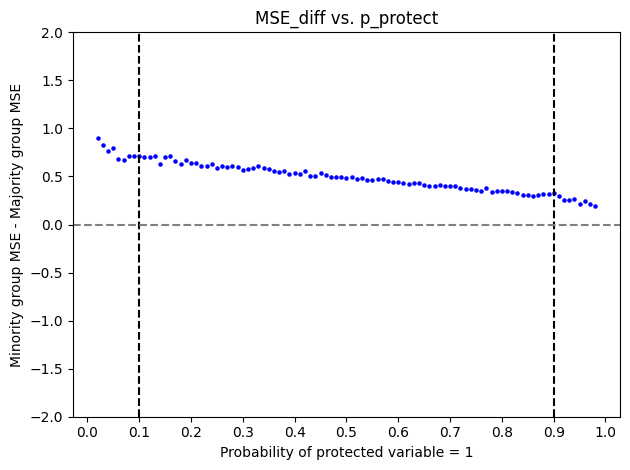

In [27]:
plot_MSEdiff_protect(p_protect, MSE_diff, "complexTau_DRLearner_linearEstimator_MSEdiffOnProb")

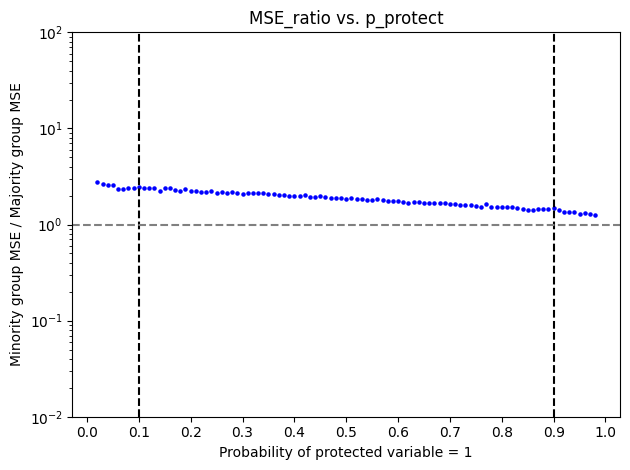

In [28]:
plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, "complexTau_DRLearner_linearEstimator_MSEratioOnProb")

In [29]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,20]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(weight=i/4)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

In [30]:
dr_learner_weight_temp = [mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list]

In [67]:
mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = dr_learner_weight_temp

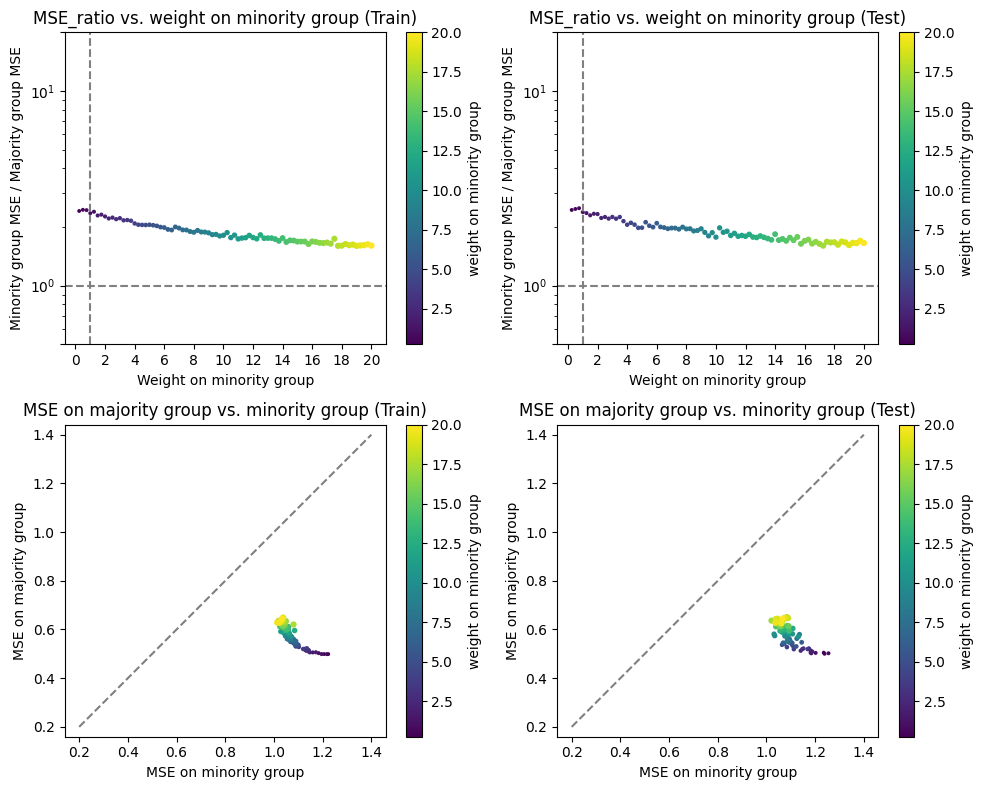

In [76]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'complexTau_DRLearner_linearEstimator_MSEViz.png', custom_yticks = [5e-1, 1e0, 1e1, 2e1], min_MSE = 0.2, max_MSE=1.4)

## Causal Forest

In [32]:
def causalForest_estimator(X, W, Y, weight_minority=1.0, n_estimators=200):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    model = CausalForest(n_estimators=n_estimators)
    model.fit(X, W, Y, sample_weight=sample_weights)
    return model

In [33]:
model = causalForest_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)[:,0]
print(np.abs(CATE_pred - Tau_train))
# seems reasonable

[0.20322721 0.22914564 0.06848413 ... 0.11202604 0.24240853 0.28147576]


In [34]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  0.161. The MSE on majority group is  0.024. The difference is  0.137.


(0.16105458662249136, 0.024344533362566315, 0.13671005325992505)

In [35]:
CATE_pred_test = model.predict(X_test)[:,0]
eval_MSE_twoGroups(CATE_pred_test, X_test, Tau_test, verbose = True)

The MSE on minority group is  0.176. The MSE on majority group is  0.022. The difference is  0.155.


(0.17626651584214562, 0.02166671349981061, 0.154599802342335)

In [36]:
def run_causalForest_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0, n=4000):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_complexTE(n=n, p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_complexTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [37]:
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation()
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

0.12659076749482767 0.010435931967950465 -0.001229663374622915 0.32028567934101276
0.1369141070902544 0.012004988472948732 -0.0038108243224114664 0.3538286945907549


In [38]:
# plot difference in MSE with respect to p_protect
p_protect = []
MSE_diff = []
MSE_minority = []
MSE_majority = []
for i in range(1, 100):
    p = i / 100
    p_protect.append(p)
    _, _, _, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(p_protect=p)
    MSE_minority.append(np.mean(MSE_minority_test))
    MSE_majority.append(np.mean(MSE_majority_test))
    MSE_diff.append(np.mean(MSE_diff_test))

In [39]:
causalForest_p_temp = [p_protect, MSE_diff, MSE_minority, MSE_majority]

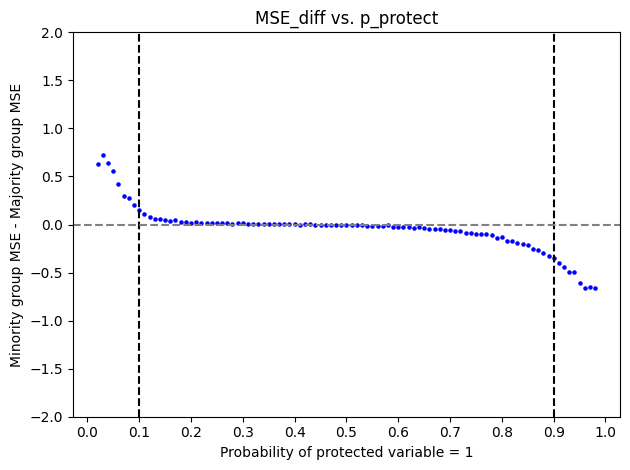

In [40]:
plot_MSEdiff_protect(p_protect, MSE_diff, "complexTau_causalForest_MSEdiffOnProb")

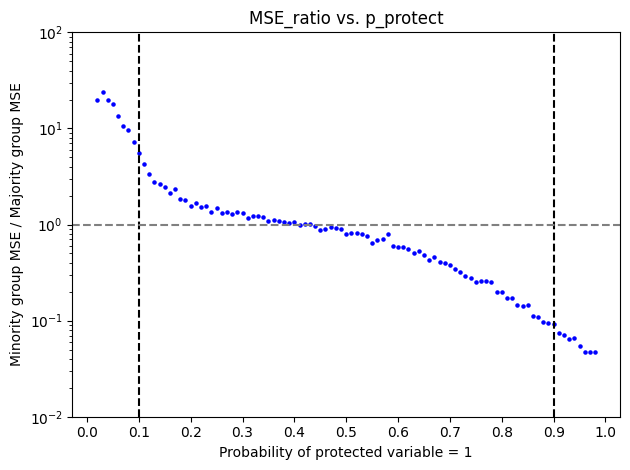

In [41]:
plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, "complexTau_causalForest_MSEratioOnProb")

In [42]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
start_time = time.time()
for i in range(1, 61):
    # mu in [0.5,30]
    mu_list.append(i/2)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i/2)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))
print("--- %s seconds ---" % (time.time() - start_time))

--- 2197.4529910087585 seconds ---


In [43]:
causalForest_weight_temp = [mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list]

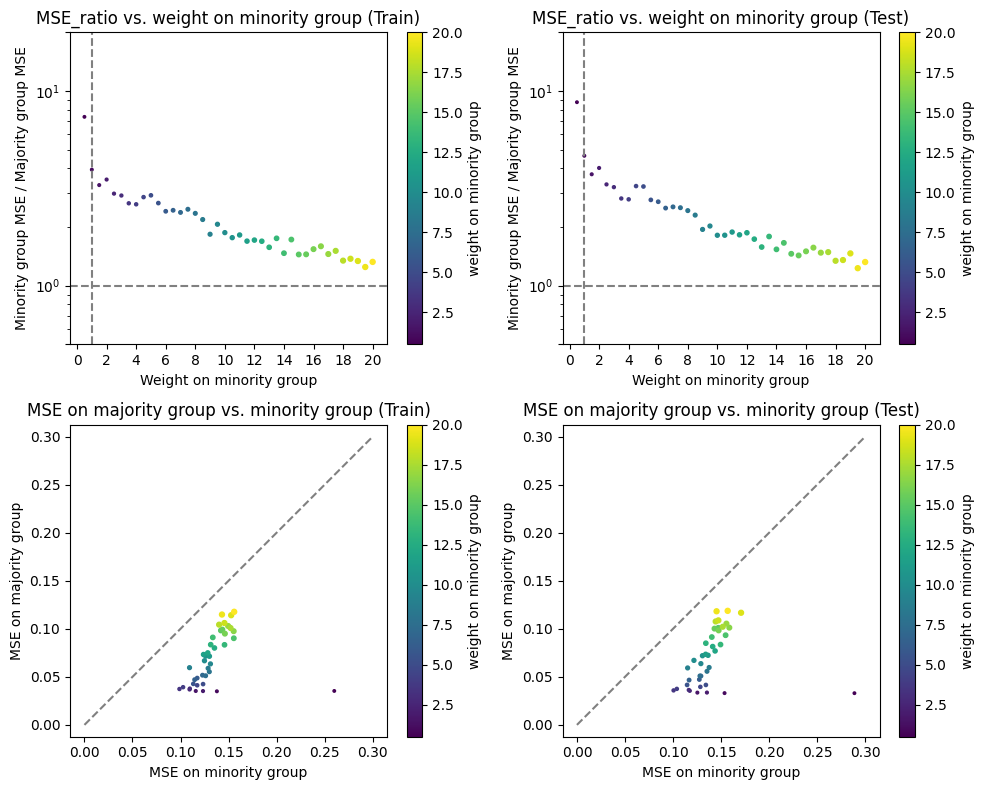

In [58]:
plot_MSE(mu_list[:40], MSE_minority_train_list[:40], MSE_majority_train_list[:40], MSE_diff_train_list[:40], 
         MSE_minority_test_list[:40], MSE_majority_test_list[:40], MSE_diff_test_list[:40], 
         'complexTau_causalForest_MSEViz.png', custom_yticks = [5e-1, 1e0, 1e1, 2e1]custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE=0.3)
# custom_xticks=[i*8 for i in range(11)], custom_yticks=[i/2 for i in range(-1, 5, 1)], min_MSE=0, max_MSE=3)

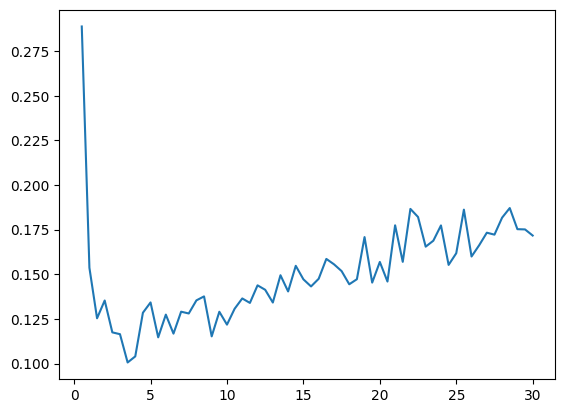

In [45]:
plt.plot(mu_list, MSE_minority_test_list)

In [46]:
MSE_minority_test_list

[0.28884300505615224,
 0.1536525463211146,
 0.12534820096281485,
 0.13530819824979848,
 0.11745849467833601,
 0.11644117756103675,
 0.10058732428476663,
 0.10399407222657096,
 0.128453302330371,
 0.1342274070474141,
 0.11467084480284923,
 0.12740332289265116,
 0.11675043336653144,
 0.12904462491188312,
 0.12804122483410255,
 0.13537965932236568,
 0.1376169764043566,
 0.11521659434207171,
 0.1290092863948205,
 0.12179216138051466,
 0.13068254737427412,
 0.1364664446209859,
 0.13395837272048927,
 0.1438087010368104,
 0.14131104554106477,
 0.13416624356968973,
 0.14946530971097885,
 0.14038644700265246,
 0.15474596674496985,
 0.14718049451322346,
 0.1431918485939363,
 0.1474858998972407,
 0.15861409242780472,
 0.15560432883271264,
 0.15178058940758798,
 0.1444033108014881,
 0.1472396473596164,
 0.17085236465221088,
 0.14533817083366388,
 0.15691228554658443,
 0.14592823361439122,
 0.17745241171228845,
 0.1569599623697339,
 0.18663202487768005,
 0.1821011707510164,
 0.16548028404285683,
 0

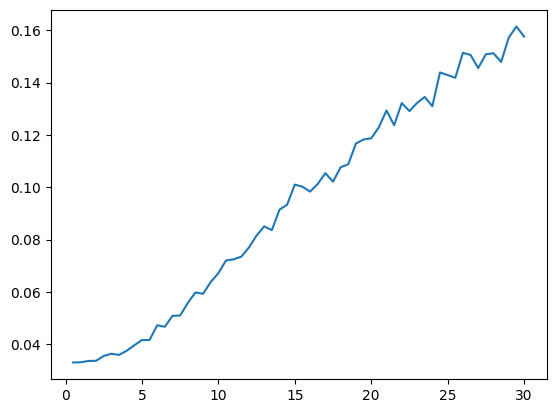

In [47]:
plt.plot(mu_list,MSE_majority_test_list)

In [48]:
MSE_majority_test_list

[0.03300159511101216,
 0.03307822235529907,
 0.033587968069974945,
 0.033649837823249346,
 0.035480983844642495,
 0.03633474501741567,
 0.03589081247308706,
 0.03748464104789509,
 0.03957664766815135,
 0.041565097452226175,
 0.04159962760311621,
 0.047237062521414366,
 0.04666351751733632,
 0.05084650857420362,
 0.05095291795705742,
 0.05575378112502746,
 0.05977512025636442,
 0.05927285639024929,
 0.06375577894229442,
 0.06714234406949364,
 0.07200226507882493,
 0.0724318042707372,
 0.0734583093829897,
 0.07696133349966976,
 0.08153846596025463,
 0.08501695848513928,
 0.083607509724691,
 0.09142974943762733,
 0.09332866593890539,
 0.10101811944842048,
 0.1002238650319722,
 0.0983313581188971,
 0.10122707068838892,
 0.1053936551237293,
 0.10213298286321776,
 0.10765542282100952,
 0.10879215003858154,
 0.11672099632339103,
 0.11825756047024048,
 0.11870861162646787,
 0.12293315519717123,
 0.12935462059596503,
 0.1237198251181562,
 0.13219268502920356,
 0.12911872224305182,
 0.1322439115

In [49]:
model = causalForest_estimator(X_train, W_train, Y_train)
model.feature_importances()

array([5.84338021e-03, 5.42680894e-01, 5.11344786e-04, 2.59990051e-01,
       1.86991807e-01, 3.98252246e-03])

In [50]:
model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=20.0)
model.feature_importances()

array([0.00544458, 0.37750639, 0.00346473, 0.5636891 , 0.03104636,
       0.01884884])

In [59]:
mu_list = mu_list[:40]
MSE_minority_test_list = MSE_minority_test_list[:40]
MSE_majority_test_list = MSE_majority_test_list[:40]
MSE_diff_test_list = MSE_diff_test_list[:40]

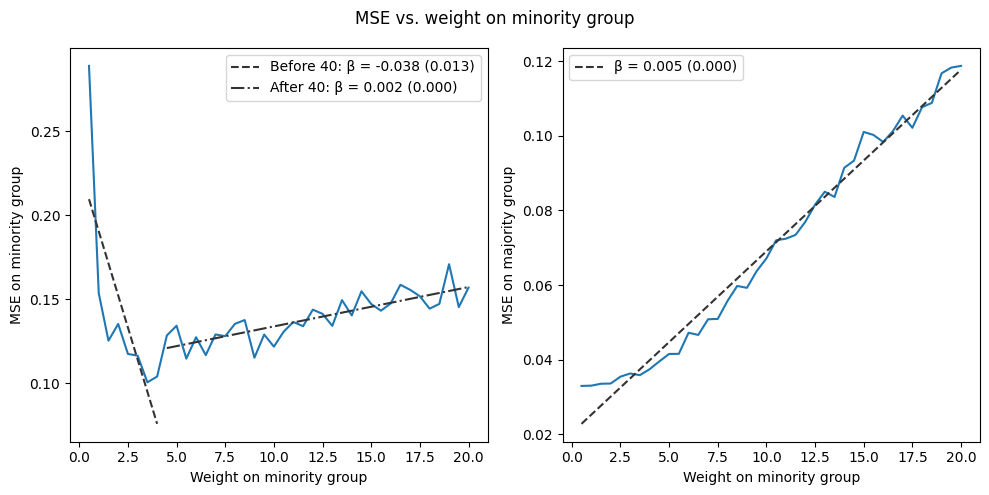

In [66]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mu_list, MSE_minority_test_list)

idx = 8
x_first_half, y_first_half = mu_list[:idx], MSE_minority_test_list[:idx]
x_second_half, y_second_half = mu_list[idx:], MSE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 40: β = {coefficients_first_half[0]:.3f} ({std_dev_first_half:.3f})', linestyle = '--', color=color)
plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 40: β = {coefficients_second_half[0]:.3f} ({std_dev_second_half:.3f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Weight on minority group')
plt.ylabel('MSE on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(mu_list, MSE_majority_test_list)

coefficients_line, cov_line = np.polyfit(mu_list, MSE_majority_test_list, 1, cov=True)

# Generating the line equations
line = np.poly1d(coefficients_line)

# Extracting standard deviation from the covariance matrix
std_dev_line = np.sqrt(np.diag(cov_line))[0]

# Plotting the lines of best fit
plt.plot(mu_list, line(mu_list), label=f'β = {coefficients_line[0]:.3f} ({std_dev_line :.3f})', linestyle = '--', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Weight on minority group')
plt.ylabel('MSE on majority group')

fig.suptitle('MSE vs. weight on minority group') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("complex_MSE_weight_best_fit", dpi=200)
plt.show()


# WGAN Synthetic Data Augmentation

In [77]:
import pandas as pd

In [78]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_complexTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_complexTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.09925 0.51325 -0.0020191209531173235
Some examples of Y: [-0.78742937 -0.11531656 -1.09786247 -1.45772149 -0.20384939]


In [79]:
train_concat = np.column_stack((np.array(W_train), np.array(X_train), np.array(Y_train)))
df_train = pd.DataFrame(train_concat, columns=['t', 'cat1', 'cat2', 'cat3', 'cont1', 'cont2', 'cont3', 'y'])

In [80]:
df_train.to_csv('df_complex_train.csv', index=False)

## After balancing protected variable

In [81]:
df_generated = pd.read_csv("df_complex_generated.csv")

In [82]:
mu1_min = (1/2) * complicated_function(df_generated.cat2) * complicated_function(df_generated.cont1)
mu1_maj = (1/2) * complicated_function(df_generated.cat2) * complicated_function(df_generated.cont2)
mu1 = (1-df_generated.cat1) * mu1_maj + df_generated.cat1 * mu1_min
mu0 = (-1/2) * complicated_function(df_generated.cat2) * complicated_function(df_generated.cont1)
tau_generated = mu1-mu0

In [83]:
pred_generated = (df_generated.y - df_generated.y_cf)*df_generated.t + (df_generated.y_cf - df_generated.y)*(1-df_generated.t)

In [84]:
mean_squared_error(tau_generated, pred_generated)

0.982561854637828

In [85]:
np.corrcoef(tau_generated, pred_generated)[0, 1]

0.695595718606826

## Synthetic Data Augmentation

In [86]:
def plot_MSE_aug(ratio_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.0):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(ratio_list, np.array(train_min) / np.array(train_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(ratio_list, np.array(test_min) / np.array(test_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.colorbar(scatter_3, label='minority group size / majority group size')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.colorbar(scatter_4, label='minority group size / majority group size')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [87]:
df_generated = pd.read_csv("df_complex_generated.csv")

In [88]:
df_generated_minority = df_generated[df_generated["cat1"] == 1]

In [89]:
df_generated_minority.shape

(485785, 10)

Try finer detail increments and run multiple times to get an average, also label the points with the amount of synthetic data added if possible

In [91]:
ratio_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
num_min = np.sum(X_train[:,0] == 1)
num_maj = np.sum(X_train[:,0] == 0)
assert(num_min + num_maj == 4000)

start_time = time.time()
for i in range(41):
    # everytime add 80 more minority data point to training set
    ratio_list.append((num_min+i*80)/num_maj)

    MSE_minority_train_temp, MSE_majority_train_temp, MSE_diff_train_temp = [], [], []
    MSE_minority_test_temp, MSE_majority_test_temp, MSE_diff_test_temp = [], [], []
    for j in range(NUM_SIMULATIONS):
        if i != 0:
            df_sampled = df_generated_minority.sample(80*i)
            X = np.vstack((X_train,df_sampled[["cat1","cat2","cat3","cont1","cont2","cont3"]].values))
            W = np.hstack((W_train,df_sampled["t"].values))
            Y = np.hstack((Y_train,df_sampled["y"].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
        model = causalForest_estimator(X, W, Y)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train_temp.append(MSE_minority)
        MSE_majority_train_temp.append(MSE_majority)
        MSE_diff_train_temp.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test_temp.append(MSE_minority)
        MSE_majority_test_temp.append(MSE_majority)
        MSE_diff_test_temp.append(MSE_diff)
    
    MSE_minority_train_list.append(np.mean(MSE_minority_train_temp))
    MSE_majority_train_list.append(np.mean(MSE_majority_train_temp))
    MSE_diff_train_list.append(np.mean(MSE_diff_train_temp))
    
    MSE_minority_test_list.append(np.mean(MSE_minority_test_temp))
    MSE_majority_test_list.append(np.mean(MSE_majority_test_temp))
    MSE_diff_test_list.append(np.mean(MSE_diff_test_temp))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 1972.3315658569336 seconds ---


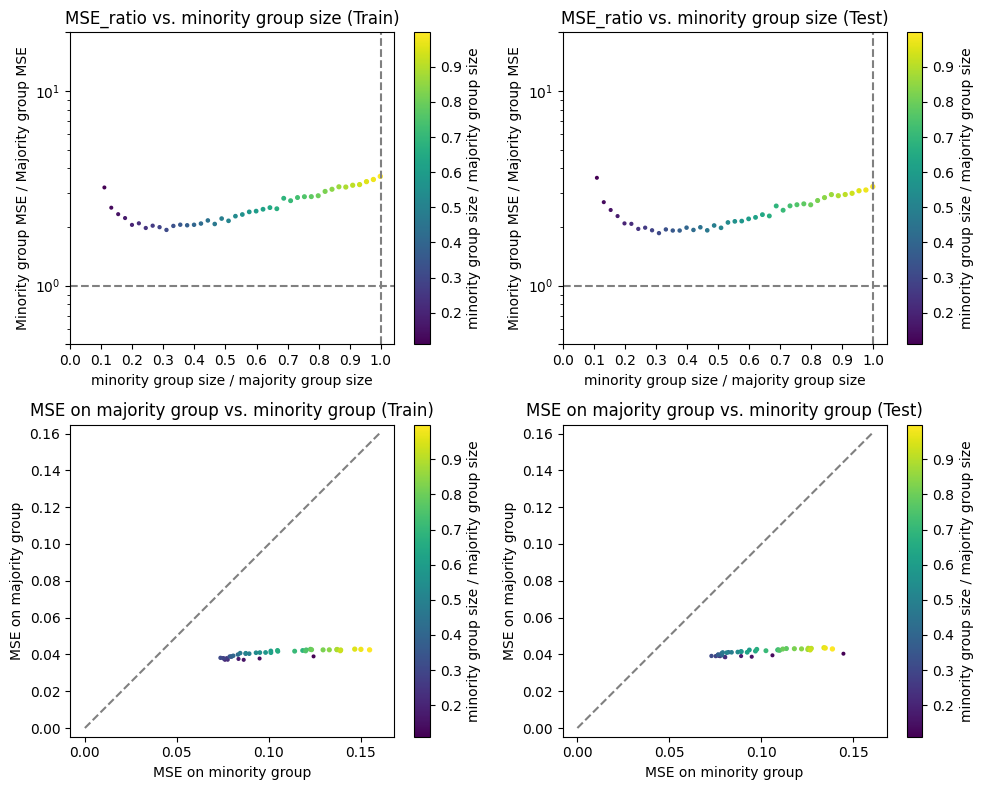

In [96]:
plot_MSE_aug(ratio_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'complexTau_causalForest_WGANAug_MSEViz.png',
         custom_xticks=[i/10 for i in range(0, 11, 1)], custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE=0.16)

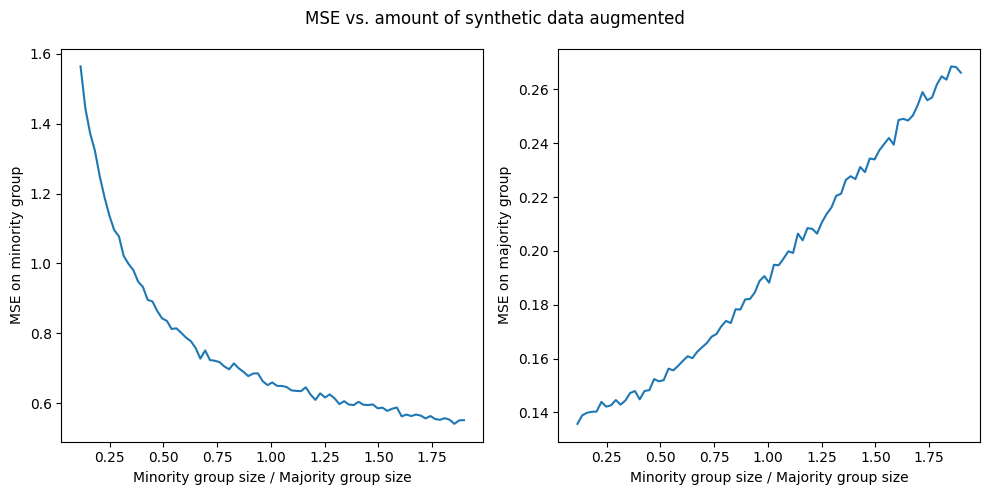

In [68]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ratio_list, MSE_minority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_minority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
# plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
# plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(ratio_list, MSE_majority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_majority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_majority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
# plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
# plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on majority group')

fig.suptitle('MSE vs. amount of synthetic data augmented') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("complexTau_MSE_augratio_best_fit", dpi=200)
plt.show()


### End of Notebook

In [ ]:
print("--- %s seconds ---" % (time.time() - global_start_time))